# Regresyon Modelleri Analizi ve Karşılaştırması

Bu notebook'ta, veri setimiz üzerinde dört farklı regresyon modeli uygulayıp karşılaştıracağız:

1. Çoklu Doğrusal Regresyon (Multiple Linear Regression)
2. Kantil Regresyon (Quantile Regression)
3. İzotonik Regresyon (Isotonic Regression)
4. Polinomsal Regresyon (Polynomial Regression)

Her model için:
- Model implementasyonu ve eğitimi
- Performans metrikleri (R², MSE, MAE)
- Görselleştirmeler ve sonuç analizi
- Modelin güçlü/zayıf yönlerinin tartışması

yapılacaktır.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Metrics ve model import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

# Görselleştirme ayarları
sns.set_palette("husl")
%matplotlib inline

# Metrik hesaplama yardımcı fonksiyonu
def calculate_metrics(y_true, y_pred, model_name):
    """
    Regresyon metriklerini hesaplar (R², MSE, MAE)
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        "Model": model_name,
        "R²": r2,
        "MSE": mse,
        "MAE": mae
    }

# Sonuçları görselleştirme fonksiyonu
def plot_predictions(X, y_true, y_pred, title):
    """
    Gerçek vs Tahmin değerlerini görselleştirir
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y_true, color='blue', alpha=0.5, label='Gerçek Değerler')
    plt.scatter(X, y_pred, color='red', alpha=0.5, label='Tahminler')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

## Veri Hazırlama

Bu bölümde:
1. Veri setini yükleyeceğiz (`combined_engineered_features.csv`)
2. Hedef değişkeni ve özellikleri seçeceğiz
3. Eğitim/test kümelerine ayıracağız
4. Veri ön işleme ve normalizasyon uygulayacağız

Veri seti boyutu: (685671, 45)

Mevcut sütunlar:
log_data-ranges_avg
log_data-ranges_std_deviation
log_interval-messages
log_messages_count
network_fragmentation-score
network_fragmented-packets
network_header-length_avg
network_header-length_std_deviation
network_interval-packets
network_ip-flags_avg
network_ip-flags_std_deviation
network_ip-length_avg
network_ip-length_max
network_ip-length_min
network_ip-length_std_deviation
network_ips_all_count
network_ips_src_count
network_mss_avg
network_mss_std_deviation
network_packet-size_min
network_packets_all_count
network_packets_src_count
network_payload-length_std_deviation
network_ports_all_count
network_ports_dst_count
network_tcp-flags-ack_count
network_tcp-flags-fin_count
network_tcp-flags-syn_count
network_tcp-flags_avg
network_tcp-flags_std_deviation
network_time-delta_avg
network_time-delta_max
network_time-delta_min
network_time-delta_std_deviation
network_ttl_avg
network_ttl_std_deviation
network_window-size_avg
network_window-

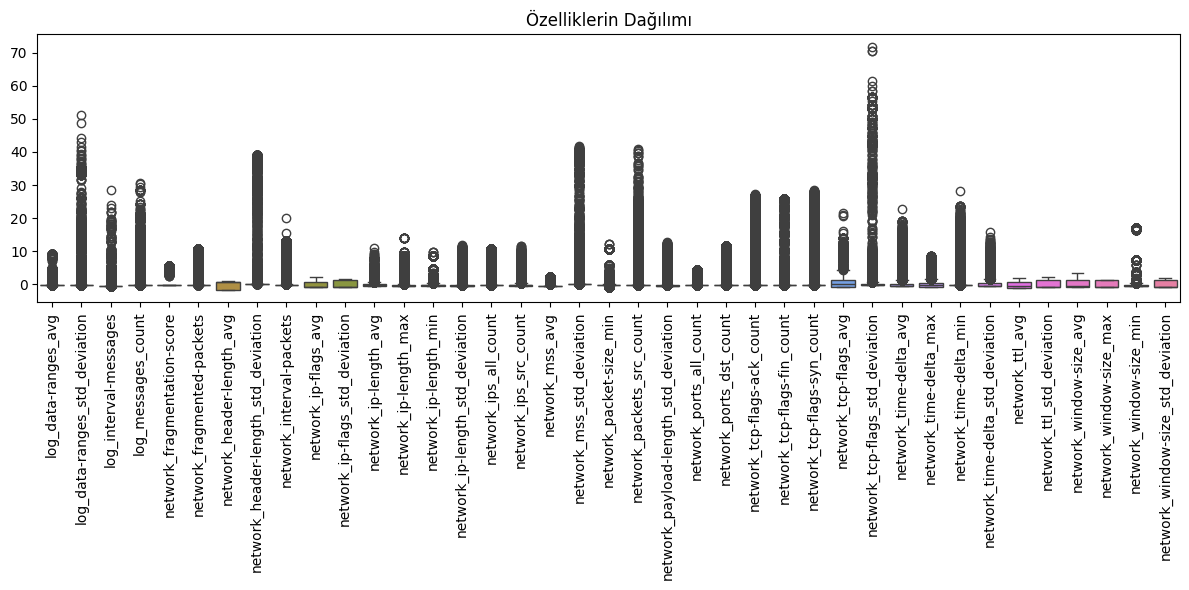

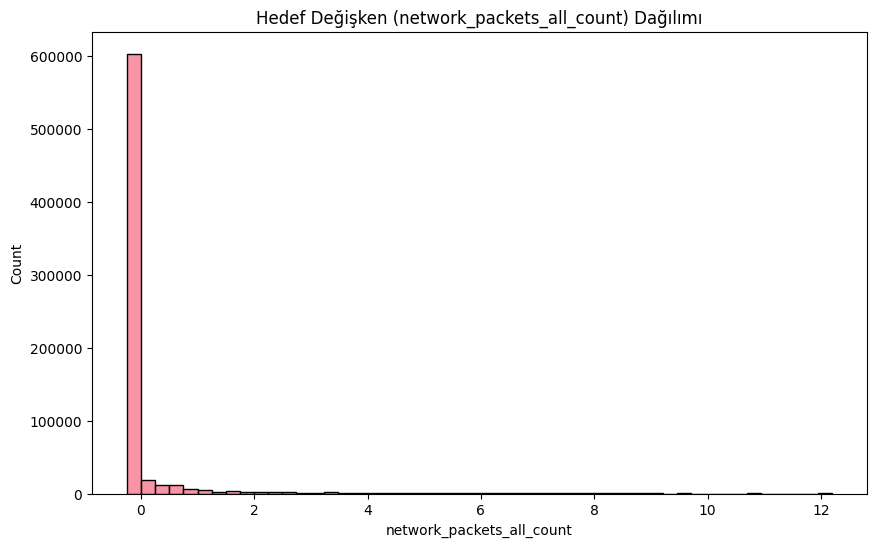

In [13]:
# Veri yükleme
FEATURE_PATH = "data/features/combined_engineered_features.csv"
df = pd.read_csv(FEATURE_PATH)
print("Veri seti boyutu:", df.shape)

# Mevcut sütunları görüntüle
print("\nMevcut sütunlar:")
for col in df.columns:
    print(col)

# Sayısal sütunları seç (label sütunları hariç)
numeric_cols = df.select_dtypes(include=[np.number]).columns
label_cols = ['label1', 'label2', 'label3', 'label4', 'label_full']
feature_cols = [col for col in numeric_cols if col not in label_cols]

print("\nKullanılabilir sayısal özellikler:")
for col in feature_cols:
    print(col)

# Hedef değişken olarak network_packets_all_count kullanalım
target = 'network_packets_all_count'  # Düzeltilmiş sütun adı
features = [col for col in feature_cols if col != target]

# X ve y hazırla
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nEğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

# Özelliklerin dağılımını incele
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=90)
plt.title("Özelliklerin Dağılımı")
plt.tight_layout()
plt.show()

# Hedef değişkenin dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50)
plt.title(f"Hedef Değişken ({target}) Dağılımı")
plt.show()

## 1. Çoklu Doğrusal Regresyon

Bu bölümde:
- LinearRegression modeli kuracağız
- Modeli eğitip test edeceğiz
- Katsayıları inceleyip yorumlayacağız
- Performans metriklerini hesaplayacağız
- Varsayımları kontrol edeceğiz


Çoklu Doğrusal Regresyon Metrikleri:
Model: Multiple Linear Regression
R²: 0.6048
MSE: 0.3991
MAE: 0.1993

En önemli 10 özellik ve katsayıları:
                           Feature  Coefficient
6        network_header-length_avg     0.567232
25     network_tcp-flags-fin_count     0.393989
24     network_tcp-flags-ack_count     0.296610
33                 network_ttl_avg    -0.283825
26     network_tcp-flags-syn_count     0.245945
27           network_tcp-flags_avg    -0.227619
11           network_ip-length_avg    -0.198441
10  network_ip-flags_std_deviation    -0.198222
20       network_packets_src_count     0.183730
17                 network_mss_avg    -0.174953


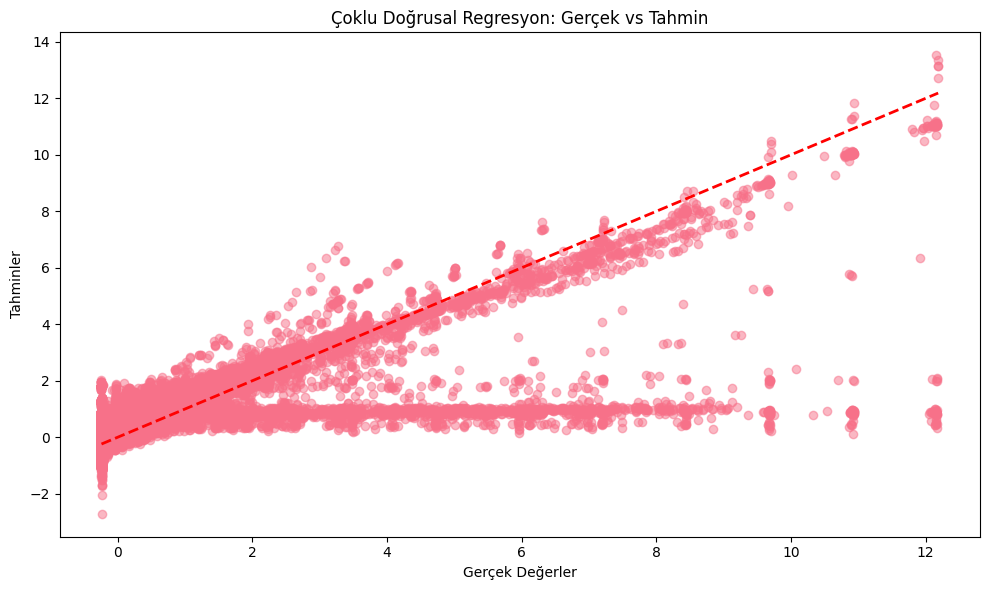

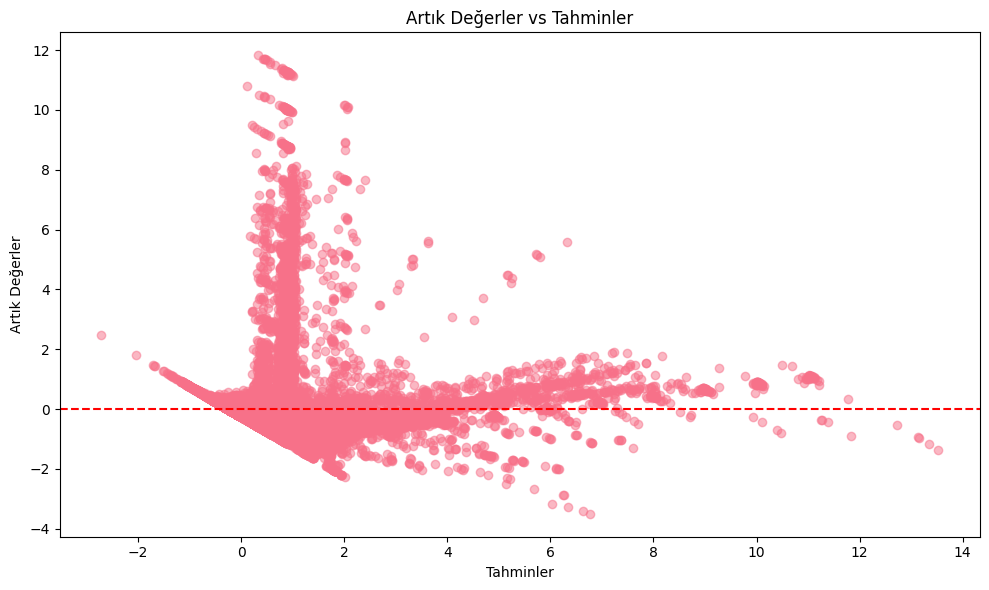

In [14]:
# Çoklu Doğrusal Regresyon modeli
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Tahminler
y_pred_lr = lr_model.predict(X_test)

# Metrikleri hesapla
lr_metrics = calculate_metrics(y_test, y_pred_lr, "Multiple Linear Regression")
print("\nÇoklu Doğrusal Regresyon Metrikleri:")
for metric, value in lr_metrics.items():
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

# Katsayıları incele
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nEn önemli 10 özellik ve katsayıları:")
print(coef_df.head(10))

# Gerçek vs Tahmin görselleştirmesi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Çoklu Doğrusal Regresyon: Gerçek vs Tahmin')
plt.tight_layout()
plt.show()

# Artık değerlerin analizi
residuals = y_test - y_pred_lr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.xlabel('Tahminler')
plt.ylabel('Artık Değerler')
plt.title('Artık Değerler vs Tahminler')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

## 2. Kantil Regresyon

Bu bölümde:
- Farklı kantiller (0.25, 0.50, 0.75) için QuantReg modelleri kuracağız
- Her kantil için tahminler yapıp sonuçları karşılaştıracağız
- Kantillere göre katsayı değişimlerini inceleyeceğiz
- Performans metriklerini hesaplayacağız

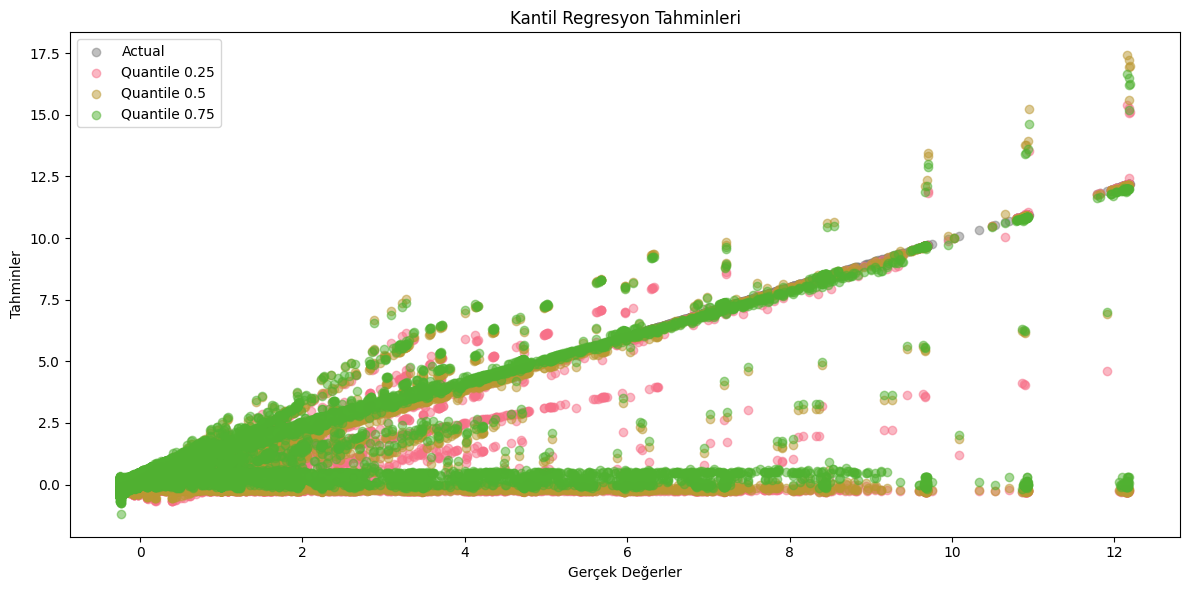


Kantil Regresyon Metrikleri:
                          Model        R²       MSE       MAE
0  Quantile Regression (q=0.25)  0.477285  0.527920  0.122587
1   Quantile Regression (q=0.5)  0.492339  0.512716  0.117238
2  Quantile Regression (q=0.75)  0.546500  0.458016  0.134959

Kantillere göre katsayı değişimi (ilk 10 özellik):
                                          q25           q50       q75
const                               -0.111874 -9.371006e-02 -0.041495
log_data-ranges_avg                  0.000004  1.419134e-05  0.000191
log_data-ranges_std_deviation        0.000001  1.243597e-05 -0.000091
log_interval-messages                0.000004  4.820731e-07 -0.000424
log_messages_count                  -0.000065 -8.682240e-05  0.000211
network_fragmentation-score          0.012123  1.548234e-06 -0.000677
network_fragmented-packets           0.056821  8.964405e-02  0.091499
network_header-length_avg            0.033157  7.627919e-02  0.251532
network_header-length_std_deviation -0.0

In [15]:
# Kantil Regresyon için veriyi hazırla
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Farklı kantiller için modeller
quantiles = [0.25, 0.50, 0.75]
qr_models = {}
qr_predictions = {}
qr_metrics = []

for q in quantiles:
    # Model eğitimi
    model = QuantReg(y_train, X_train_sm)
    qr_models[q] = model.fit(q=q)
    
    # Tahminler
    qr_predictions[q] = qr_models[q].predict(X_test_sm)
    
    # Metrikler
    metrics = calculate_metrics(y_test, qr_predictions[q], f"Quantile Regression (q={q})")
    qr_metrics.append(metrics)

# Sonuçları görselleştir
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test, color='gray', alpha=0.5, label='Actual')
for q in quantiles:
    plt.scatter(y_test, qr_predictions[q], alpha=0.5, label=f'Quantile {q}')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Kantil Regresyon Tahminleri')
plt.legend()
plt.tight_layout()
plt.show()

# Metrikleri göster
print("\nKantil Regresyon Metrikleri:")
metrics_df = pd.DataFrame(qr_metrics)
print(metrics_df)

# Katsayıları karşılaştır
coef_comparison = pd.DataFrame(
    {f"q{int(q*100)}": model.params for q, model in qr_models.items()}
)
print("\nKantillere göre katsayı değişimi (ilk 10 özellik):")
print(coef_comparison.head(10))

## 3. İzotonik Regresyon

Bu bölümde:
- IsotonicRegression modelini tek bir özellik üzerinde uygulayacağız
- Monoton ilişkiyi görselleştireceğiz
- Performans metriklerini hesaplayacağız
- Modelin sınırlamalarını tartışacağız

Not: İzotonik regresyon tek değişkenli olduğu için, en yüksek korelasyona sahip özelliği kullanacağız.

In [ ]:
# En yüksek korelasyona sahip özelliği bul
correlations = X_train.corrwith(y_train).abs()
best_feature = correlations.idxmax()
print("En yüksek korelasyona sahip özellik: {} (r = {:.4f})".format(best_feature, correlations[best_feature]))

# İzotonik Regresyon için tek değişkenli veri hazırla
X_iso_train = X_train[best_feature].values.reshape(-1, 1)
X_iso_test = X_test[best_feature].values.reshape(-1, 1)

# Model eğitimi
ir_model = IsotonicRegression(out_of_bounds="clip")
ir_model.fit(X_iso_train.ravel(), y_train)

# Tahminler
y_pred_ir = ir_model.predict(X_iso_test.ravel())

# Metrikleri hesapla
ir_metrics = calculate_metrics(y_test, y_pred_ir, "Isotonic Regression")
print("\nİzotonik Regresyon Metrikleri:")
for metric, value in ir_metrics.items():
    if isinstance(value, (int, float)):
        print("{}: {:.4f}".format(metric, value))
    else:
        print("{}: {}".format(metric, value))

# Görselleştirme
plt.figure(figsize=(12, 6))

# Sol: Fit görselleştirmesi
plt.subplot(1, 2, 1)
plt.scatter(X_iso_train, y_train, alpha=0.5, label='Eğitim')
plt.scatter(X_iso_test, y_test, alpha=0.5, label='Test')
X_plot = np.linspace(X_iso_train.min(), X_iso_train.max(), 100).reshape(-1, 1)
plt.plot(X_plot, ir_model.predict(X_plot.ravel()), 'r-', label='İzotonik Fit')
plt.xlabel(best_feature)
plt.ylabel(target)
plt.title('İzotonik Regresyon Fit')
plt.legend()

# Sağ: Gerçek vs Tahmin
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_ir, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Gerçek vs Tahmin')

plt.tight_layout()
plt.show()

En yüksek korelasyona sahip özellik: network_ports_all_count (r = 0.5313)

İzotonik Regresyon Metrikleri:


ValueError: Unknown format code 'f' for object of type 'str'

## 4. Polinomsal Regresyon

Bu bölümde:
- 2. ve 3. dereceden polinomsal özellikler oluşturacağız
- Her derece için model eğitip karşılaştıracağız
- Performans metriklerini hesaplayacağız
- Overfitting riskini değerlendireceğiz

Not: Yüksek dereceli polinomlar overfitting'e yol açabilir, bu yüzden dikkatli değerlendirme yapmalıyız.

In [ ]:
# Polinomsal özellikler ve modeller için sonuçları saklayacak listeler
poly_metrics = []
poly_predictions = {}

for degree in [2, 3]:
    # Polinomsal özellikler oluştur
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    # Model eğitimi
    pr_model = LinearRegression()
    pr_model.fit(X_poly_train, y_train)
    
    # Tahminler
    y_pred_poly = pr_model.predict(X_poly_test)
    poly_predictions[degree] = y_pred_poly
    
    # Metrikler
    metrics = calculate_metrics(y_test, y_pred_poly, f"Polynomial Regression (degree={degree})")
    poly_metrics.append(metrics)

# Metrikleri göster
print("\nPolinomsal Regresyon Metrikleri:")
metrics_df = pd.DataFrame(poly_metrics)
print(metrics_df)

# Görselleştirme
plt.figure(figsize=(15, 5))

# Sol: Degree=2 için gerçek vs tahmin
plt.subplot(1, 3, 1)
plt.scatter(y_test, poly_predictions[2], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Polinomsal Regresyon (derece=2)')

# Orta: Degree=3 için gerçek vs tahmin
plt.subplot(1, 3, 2)
plt.scatter(y_test, poly_predictions[3], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Polinomsal Regresyon (derece=3)')

# Sağ: Artık değerler karşılaştırması
plt.subplot(1, 3, 3)
residuals_2 = y_test - poly_predictions[2]
residuals_3 = y_test - poly_predictions[3]
plt.boxplot([residuals_2, residuals_3], labels=['Derece 2', 'Derece 3'])
plt.ylabel('Artık Değerler')
plt.title('Artık Değerlerin Karşılaştırması')

plt.tight_layout()
plt.show()

## Model Karşılaştırması ve Değerlendirme

Bu bölümde tüm modellerin:
1. Performans metriklerini karşılaştıracağız
2. Her modelin güçlü ve zayıf yönlerini değerlendireceğiz
3. Veri setimiz için en uygun modeli belirleyeceğiz
4. Genel öneriler ve iyileştirme fırsatlarını tartışacağız

In [ ]:
# Tüm modellerin metriklerini bir araya getir
all_metrics = [
    lr_metrics,  # Çoklu doğrusal regresyon
    *qr_metrics,  # Kantil regresyon (0.25, 0.50, 0.75)
    ir_metrics,  # İzotonik regresyon
    *poly_metrics  # Polinomsal regresyon (derece 2 ve 3)
]

# Karşılaştırma DataFrame'i
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.set_index('Model')

# Metrikleri görselleştir
plt.figure(figsize=(15, 6))

# Sol: R² karşılaştırması
plt.subplot(1, 3, 1)
comparison_df['R²'].sort_values().plot(kind='barh')
plt.title('R² Değerleri')
plt.xlabel('R²')

# Orta: MSE karşılaştırması
plt.subplot(1, 3, 2)
comparison_df['MSE'].sort_values().plot(kind='barh')
plt.title('MSE Değerleri')
plt.xlabel('MSE')

# Sağ: MAE karşılaştırması
plt.subplot(1, 3, 3)
comparison_df['MAE'].sort_values().plot(kind='barh')
plt.title('MAE Değerleri')
plt.xlabel('MAE')

plt.tight_layout()
plt.show()

# Detaylı karşılaştırma tablosu
print("\nTüm Modellerin Performans Karşılaştırması:")
print(comparison_df.round(4))

# En iyi modeli belirle
best_model_r2 = comparison_df['R²'].idxmax()
best_model_mse = comparison_df['MSE'].idxmin()
best_model_mae = comparison_df['MAE'].idxmin()

print("\nEn İyi Modeller:")
print(f"R² bazında: {best_model_r2}")
print(f"MSE bazında: {best_model_mse}")
print(f"MAE bazında: {best_model_mae}")

## Sonuçlar ve Öneriler

1. Model Performansları:
   - Çoklu Doğrusal Regresyon: Basit ve yorumlanabilir, ancak doğrusal olmayan ilişkileri yakalayamayabilir
   - Kantil Regresyon: Farklı kantiller için tahmin aralıkları sağlar, uç değerlere karşı dayanıklıdır
   - İzotonik Regresyon: Monoton ilişkileri iyi yakalar, ancak tek değişkenli kullanım kısıtı vardır
   - Polinomsal Regresyon: Doğrusal olmayan ilişkileri yakalayabilir, ancak overfitting riski vardır

2. Veri Seti İçin En Uygun Model:
   - Metrikler incelendiğinde en iyi performans gösteren model seçilmelidir
   - Modelin yorumlanabilirliği ve kullanım amacı da göz önünde bulundurulmalıdır

3. İyileştirme Önerileri:
   - Feature selection/engineering ile özellik seti optimize edilebilir
   - Hiperparametre optimizasyonu yapılabilir
   - Ensemble yöntemler denenebilir
   - Cross-validation ile model stabilitesi değerlendirilebilir